**Scenario A**

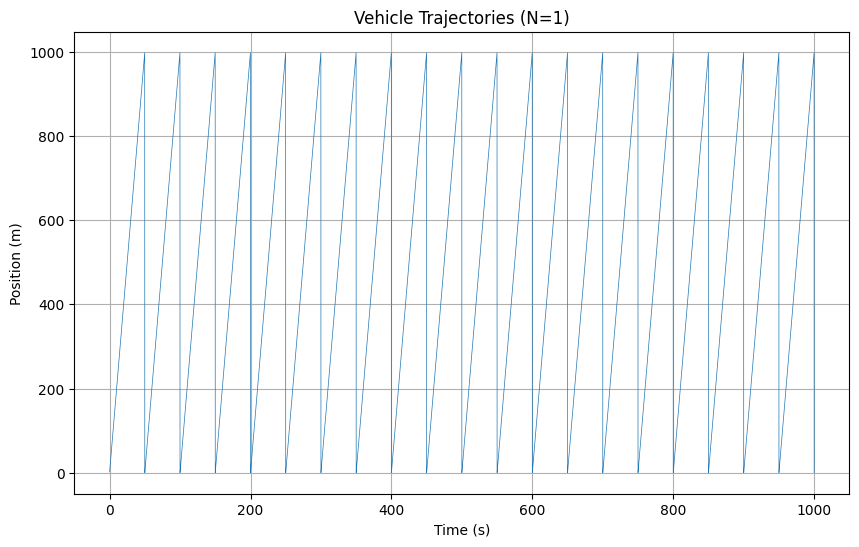

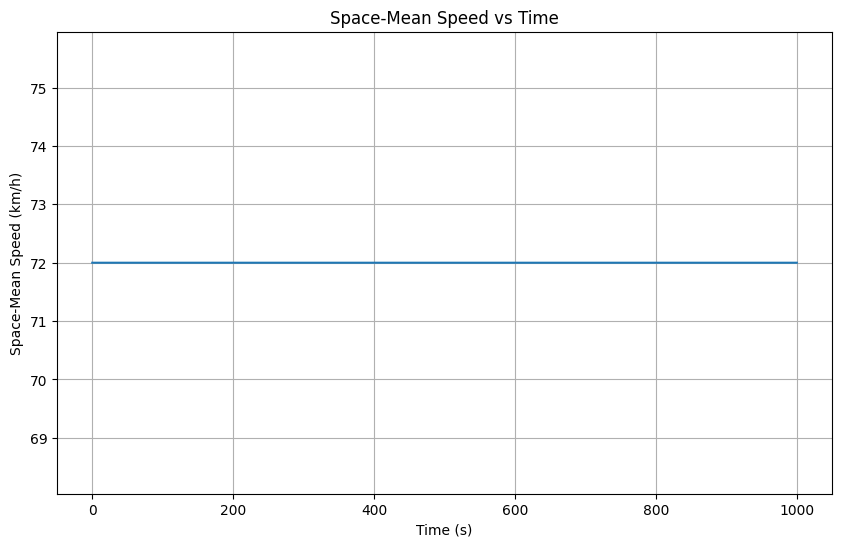

Generating Fundamental Diagram...
N=1: q=72.0 veh/h
N=2: q=144.0 veh/h
N=3: q=216.0 veh/h
N=4: q=288.0 veh/h
N=5: q=360.0 veh/h
N=6: q=432.0 veh/h
N=7: q=504.0 veh/h
N=8: q=576.0 veh/h
N=9: q=648.0 veh/h
N=10: q=720.0 veh/h
N=11: q=792.0 veh/h
N=12: q=864.0 veh/h
N=13: q=936.0 veh/h
N=14: q=1008.0 veh/h
N=15: q=1080.0 veh/h
N=16: q=1152.0 veh/h
N=17: q=1224.0 veh/h
N=18: q=1296.0 veh/h
N=19: q=1368.0 veh/h
N=20: q=1440.0 veh/h
N=21: q=1512.0 veh/h
N=22: q=1584.0 veh/h
N=23: q=1593.0 veh/h
N=24: q=1584.0 veh/h
N=25: q=1575.0 veh/h
N=26: q=1566.0 veh/h
N=27: q=1557.0 veh/h
N=28: q=1548.0 veh/h
N=29: q=1539.0 veh/h
N=30: q=1530.0 veh/h
N=31: q=1521.0 veh/h
N=32: q=1512.0 veh/h
N=33: q=1503.0 veh/h
N=34: q=1494.0 veh/h
N=35: q=1485.0 veh/h
N=36: q=1476.0 veh/h
N=37: q=1467.0 veh/h
N=38: q=1458.0 veh/h
N=39: q=1449.0 veh/h
N=40: q=1440.0 veh/h
N=41: q=1431.0 veh/h
N=42: q=1422.0 veh/h
N=43: q=1413.0 veh/h
N=44: q=1404.0 veh/h
N=45: q=1395.0 veh/h
N=46: q=1386.0 veh/h
N=47: q=1377.0 veh/h
N=

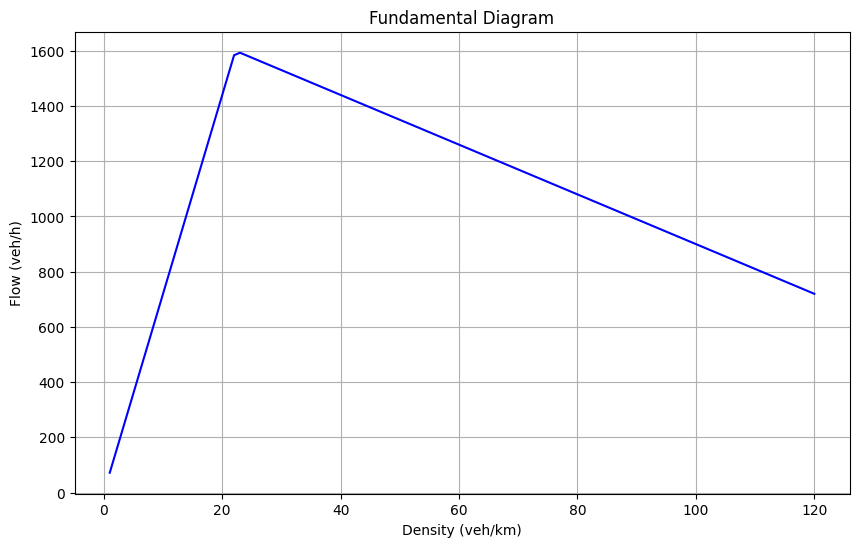

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
road_length = 1000  # meters
tau = 2.0  # time gap (s)
L = 5.0  # vehicle length (m)
delta_t = 0.1  # simulation time step (s)
v_f = 20.0  # free-flow speed (m/s) - assumed value
simulation_time = 1000  # seconds for single simulation
steady_window = 1000  # last 1000 steps to check steady state

def simulate(N, sim_time):
    time_steps = int(sim_time / delta_t)
    x = np.array([(i * road_length / N) % road_length for i in range(N)])
    velocities = np.full(N, v_f)
    
    traj = np.zeros((time_steps, N))
    speeds = np.zeros((time_steps, N))
    
    for t in range(time_steps):
        # Update velocities
        for n in range(N):
            leader = (n + 1) % N
            dx = (x[leader] - x[n]) % road_length
            if dx < 1e-9:  # Handle N=1 case
                dx = road_length
            gap = max(0, dx - L)
            new_v = min(gap / tau, v_f)
            velocities[n] = new_v
        
        # Update positions
        x = (x + velocities * delta_t) % road_length
        traj[t, :] = x
        speeds[t, :] = velocities
    
    sms = np.mean(speeds, axis=1)
    return traj, sms

def plot_trajectories(traj, N):
    plt.figure(figsize=(10, 6))
    time_axis = np.arange(traj.shape[0]) * delta_t
    for vehicle in range(N):
        plt.plot(time_axis, traj[:, vehicle], linewidth=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(f'Vehicle Trajectories (N={N})')
    plt.grid(True)
    plt.show()

def plot_sms(sms):
    plt.figure(figsize=(10, 6))
    time_axis = np.arange(len(sms)) * delta_t
    plt.plot(time_axis, sms * 3.6)  # Convert to km/h
    plt.xlabel('Time (s)')
    plt.ylabel('Space-Mean Speed (km/h)')
    plt.title('Space-Mean Speed vs Time')
    plt.grid(True)
    plt.show()

def generate_mfd():
    N_values = range(1, 121)
    k_values = []
    q_values = []
    
    for N in N_values:
        traj, sms = simulate(N, 500)
        steady_sms = np.mean(sms[-steady_window:])  # Last 100 seconds
        k = N  # veh/km (road length is 1 km)
        q = k * (steady_sms * 3.6)  # veh/h
        k_values.append(k)
        q_values.append(q)
        print(f'N={N}: q={q:.1f} veh/h')
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, q_values, 'b-')
    plt.xlabel('Density (veh/km)')
    plt.ylabel('Flow (veh/h)')
    plt.title('Fundamental Diagram')
    plt.grid(True)
    plt.show()

# Main code
if __name__ == "__main__":
    N = int(input("Enter number of vehicles (1-120): "))
    if N < 1 or N > 120:
        raise ValueError("N must be between 1 and 120")
    
    # Simulate for user's N
    traj, sms = simulate(N, simulation_time)
    plot_trajectories(traj, N)
    plot_sms(sms)
    
    # Generate MFD (this may take several minutes)
    print("Generating Fundamental Diagram...")
    generate_mfd()

**Scenario B - 0.5 green light ratio**

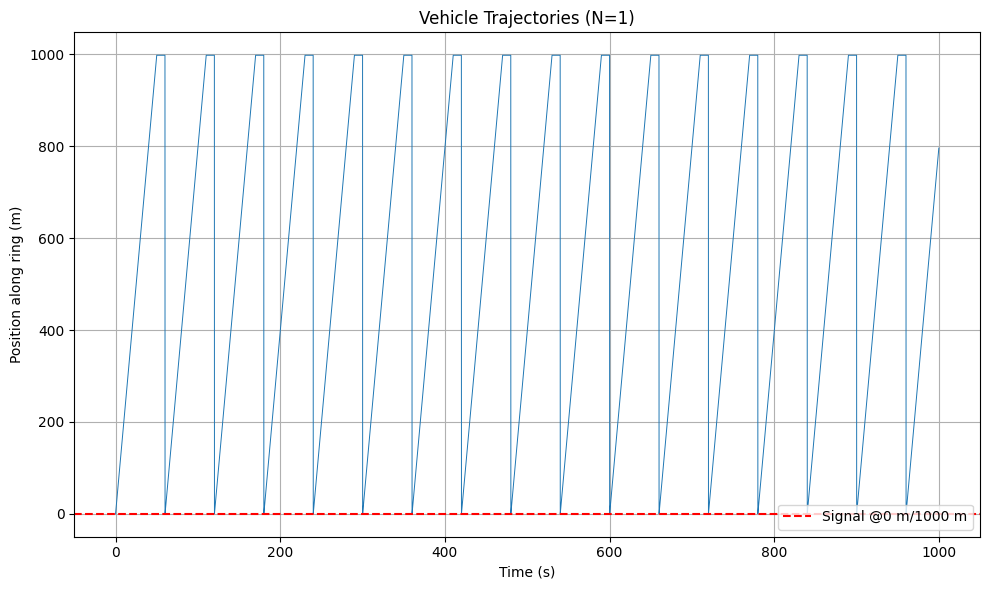

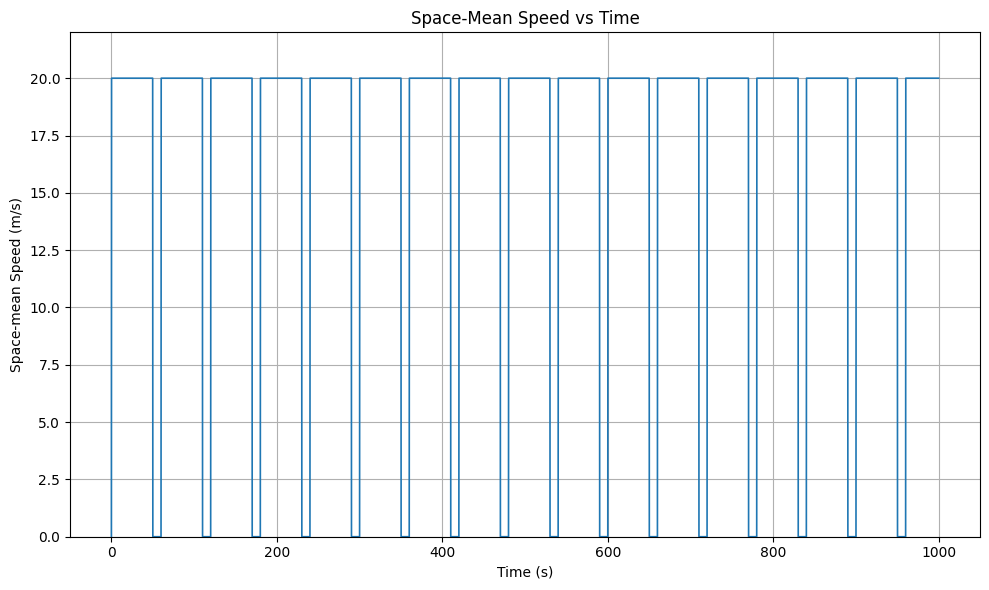

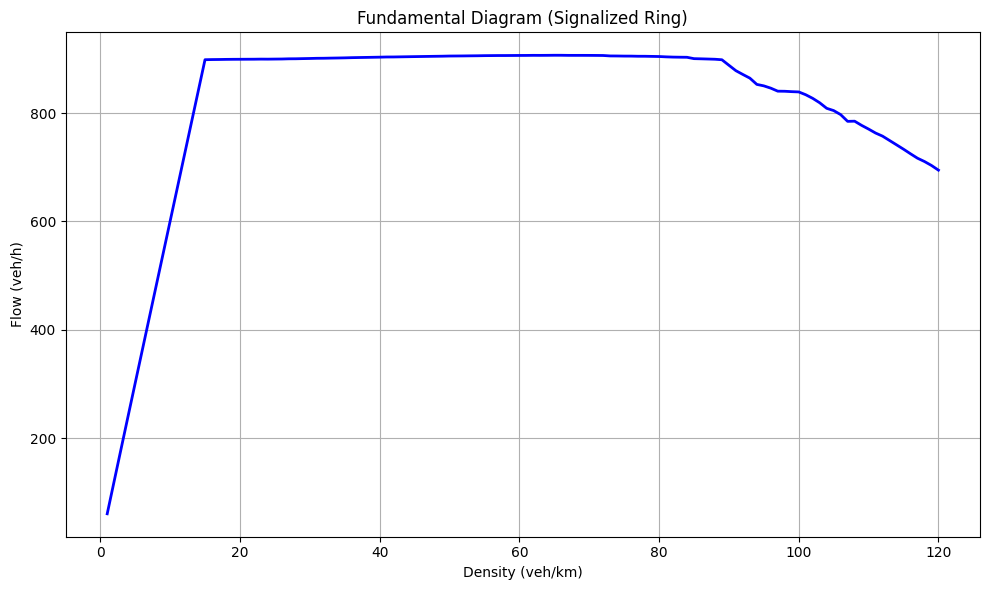

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# === Global Parameters ===
road_length     = 1000.0   # meters (circumference)
tau             = 2.0      # time gap (s)
L_vehicle       = 5.0      # vehicle length (m)
delta_t         = 0.1      # simulation time step (s)
v_f             = 20.0     # free-flow speed (m/s)
simulation_time = 1000.0   # seconds for trajectories & SMS
cycle_time      = 60.0     # traffic signal cycle (s)
green_ratio     = 0.5      # fraction of cycle that is green
signal_pos      = 0.0      # signal at starting point (0 m)

def simulate_signal(N, sim_time):
    time_steps = int(sim_time / delta_t)
    pos_abs = np.linspace(0, road_length, N, endpoint=False)
    velocities = np.zeros(N)
    
    traj   = np.zeros((time_steps, N))
    speeds = np.zeros((time_steps, N))

    for t in range(time_steps):
        current_time = t * delta_t
        is_green = (current_time % cycle_time) < (cycle_time * green_ratio)
        
        traj[t]   = pos_abs
        speeds[t] = velocities
        
        for i in range(N):
            leader = (i + 1) % N
            # compute gap CCW
            if pos_abs[leader] > pos_abs[i]:
                gap = pos_abs[leader] - pos_abs[i] - L_vehicle
            else:
                gap = (pos_abs[leader] + road_length) - pos_abs[i] - L_vehicle
            gap = max(gap, 0.0)
            v_cand = min(gap / tau, v_f)
            
            # red‐light enforcement at 0 m
            if not is_green:
                next_pos = pos_abs[i] + v_cand * delta_t
                # crossing the wrap point means hitting the signal
                if next_pos >= road_length:
                    velocities[i] = 0.0
                else:
                    velocities[i] = v_cand
            else:
                velocities[i] = v_cand
        
        # advance positions CCW and wrap
        pos_abs += velocities * delta_t
        pos_abs[pos_abs >= road_length] -= road_length

    sms = np.mean(speeds, axis=1)
    return traj, sms

def plot_trajectories(traj, N):
    t = np.arange(traj.shape[0]) * delta_t
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(t, traj[:, i], linewidth=0.7)
    plt.axhline(signal_pos, color='r', linestyle='--', label='Signal @0 m/1000 m')
    plt.xlabel('Time (s)')
    plt.ylabel('Position along ring (m)')
    plt.title(f'Vehicle Trajectories (N={N})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_sms(sms):
    t = np.arange(len(sms)) * delta_t
    plt.figure(figsize=(10, 6))
    plt.plot(t, sms, linewidth=1.2)
    plt.xlabel('Time (s)')
    plt.ylabel('Space‐mean Speed (m/s)')
    plt.title('Space‐Mean Speed vs Time')
    plt.ylim(0, v_f * 1.1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_mfd():
    Ns = np.arange(1, 121)
    q_vals = []
    for N in Ns:
        _, sms = simulate_signal(N, simulation_time)
        stable_sms = sms[int(0.3 * len(sms)):]   # discard first 30%
        v_avg = stable_sms.mean()
        # flow q = k * v_avg * 3600, with k = N veh/km
        q = N * v_avg * 3600 / road_length
        q_vals.append(q)
    
    plt.figure(figsize=(10, 6))
    plt.plot(Ns, q_vals, 'b-', linewidth=2)
    plt.xlabel('Density (veh/km)')
    plt.ylabel('Flow (veh/h)')
    plt.title('Fundamental Diagram (Signalized Ring)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    N = int(input("Enter number of vehicles (1–120): "))
    traj, sms = simulate_signal(N, simulation_time)
    plot_trajectories(traj, N)
    plot_sms(sms)
    plot_mfd()
